# Classifier on Features
1. Extract final features from resnet for each tile
2. The 2048 dim features from each tile are mapped to a 1 dim feature by using a convolutional layer.
3. The output is vector of length num_tiles. Then we take the min and max 5 values.
4. the 10 values are fed into an MLP with 200-100-2 nodes

Differences:
* Not using full number of tiles (/10)
* Not sampling tiles using fixed grid, just randomly
* What tiles are scanned at 20x or 40x resolution?

In [9]:
import os
import sys
import glob
import random
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.models as models


%reload_ext autoreload
%autoreload 2
%matplotlib inline

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
torch.cuda.set_device(1)
print(torch.cuda.current_device())
cuda=True

# Base Directory where data is stored
base_data_dir = ''
ex_img = '/media/rene/Data/camelyon_out/global_label_tiles_224_10/train/normal/Normal_029/Normal_029_1'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
1


In [10]:
resnet50 = models.resnet50(pretrained=True)
resnet50.cuda()
resnet50_feat = nn.Sequential(*list(resnet50.children())[:-1])

(1355, 2048)


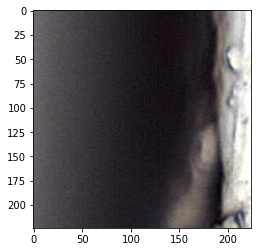

In [11]:
feat = np.load('/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_014.npy')
print(feat.shape)

imshow(Image.open(ex_img))

# NN for the features

In [27]:
# Data Loader
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import glob
from random import shuffle

def stack_var_size(sample, pad_length=False):
    if len(sample[0].shape) == 2: # we have a 1 Dimensional series. Assume format is [channels, length]
        # pad the length to with 0s to be the maximum length of any in the batch
        if not pad_length:
            pad_length = max([obs.shape[-1] for obs in sample])
        padded_sample = []
        for obs in sample:
            result = np.zeros((sample[0].shape[0], pad_length))
            result[:obs.shape[0],:obs.shape[1]] = obs
            padded_sample.append(result)

    elif len(sample[0].shape) == 3: # we have an image
        print('error images batch gen not implemented yet', batch[0].shape)
    elif len(sample[0].shape) == 1:
        return np.stack(sample)
    return np.array(padded_sample)

def np_collate_var_size(batch):
    "Puts each data field into a tensor with outer dimension batch size. Must be numpy format input"
    pad_length = False
    if isinstance(batch[0], (np.ndarray, np.generic)):
        return stack_var_size(batch, pad_length)
    elif isinstance(batch[0], int):
        return torch.LongTensor(batch)
    elif isinstance(batch[0], float):
        return torch.DoubleTensor(batch)
    elif isinstance(batch[0], (str, bytes)):
        return batch
    elif isinstance(batch, collections.Sequence):
        transposed = zip(*batch)
        return [np_collate_var_size(samples) for samples in transposed]
    raise TypeError(("batch must contain numpy array or numbers, numbers; found {}"
                     .format(type(batch[0]))))

class FeaturesDataset(Dataset):
    """Reading in extracted features from resnet50. Input data is backwards [features, observations].
    """
    SEED = 101
    random.seed(SEED)

    def __init__(self, data_loc, samp=False):
        self.all_data = glob.glob(data_loc+'/**/*.npy', recursive=True)
        if samp:
            self.all_data = self.all_data[0:10]

    def __getitem__(self, index):
        """This returns an individual numpy array for the data and label"""
        feat = np.load(self.all_data[index])

        # Convert to proper dim ordering. Leave as numpy for collate function
        feat = np.swapaxes(feat,0,1)
                              
        # get the label
        if 'normal' in self.all_data[index]:
            label = 0
        elif 'tumor' in self.all_data[index]:
            label = 1
        else: # how will the test set work? Are these labels just ignored?
            label = 9 
        label = np.expand_dims(label, 0) # what is this???
        label = np.expand_dims(label, 0)
        
        return feat, label

    def __len__(self):
        return len(self.all_data)

In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.sampler as sampler

# input dim ordering in pytorch is batch_size, channels, (other dims)

class ChowderNet(nn.Module):
    def __init__(self):
        super(ChowderNet, self).__init__()
        # (channelsin=2048, kernel_size=1, this only spans the channels)
        self.conv1 = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)        
        self.fc1 = nn.Linear(10, 200)
#         self.s1 = nn.Sigmoid()
        self.s1 = nn.ReLU()
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
#         self.s2 = nn.Sigmoid()
        self.s2 = nn.ReLU()
        self.fc2_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 1)
        self.s3 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)        
        max_5 = torch.topk(x, k=5, largest=True)
        min_5 = torch.topk(x, k=5, largest=False)
        max_5 = max_5[0]
        min_5 = min_5[0]
        x = torch.cat((max_5, min_5), 2)
        
        # Fully connected:
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.fc2_drop(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.s3(x)
        return x
    

https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
https://github.com/pytorch/pytorch/blob/476d85dd3f8ee48f6affc836d5c7fbd8ccfab200/torch/utils/data/dataloader.py#L63
https://github.com/fastai/fastai/blob/master/fastai/dataloader.py

In [24]:
train_loc = '/media/rene/Data/camelyon_out/global_label_features_224_10/train'
valid_loc = '/media/rene/Data/camelyon_out/global_label_features_224_10/valid'

train_dataset = FeaturesDataset(train_loc, samp=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=1, collate_fn=np_collate_var_size)

valid_dataset = FeaturesDataset(valid_loc, samp=True)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False, num_workers=1, collate_fn=np_collate_var_size)

In [22]:
import collections

epochs = 3

model = ChowderNet()
model.cuda()
loss_fn = nn.BCELoss()  
# optimizer = torch.optim.Adam([
#                             {'params': model.conv1.weight, 'weight_decay': .5},
#                             {'params': model.conv1.bias, 'weight_decay': .5},
#                             {'params': model.fc1.weight, 'weight_decay': 0},
#                             {'params': model.fc1.bias, 'weight_decay': 0},
#                             {'params': model.fc2.weight, 'weight_decay': 0},
#                             {'params': model.fc2.bias, 'weight_decay': 0},
#                             ], lr = 0.001)

optimizer = torch.optim.Adam(model.parameters(), lr = .001)

def get_valid_loss():
    model.eval()
    valid_loss = 0
    correct = 0
    num_data=0
    for data, target in valid_loader:
        num_data+=len(target)
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        target = torch.from_numpy(target).type(torch.FloatTensor)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += loss_fn(output, target)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = target.type(torch.cuda.LongTensor)
        
#         print(np.column_stack((np.squeeze(target.data.cpu().numpy()), np.squeeze(output.data.cpu().numpy()))))

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    valid_loss /= num_data
    valid_acc = 100. * correct / num_data
    return valid_loss, valid_acc

for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        target = torch.from_numpy(target).type(torch.FloatTensor) 
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
#         print('target: ', target.data.cpu().numpy())
#         print('output: ', output.data.cpu().numpy())

    valid_loss, valid_acc = get_valid_loss()
    print('-------Epoch: ', epoch)
    print('train loss: ', loss.data.cpu().numpy())
    print('valid_loss: ', valid_loss.data[0])
    print('valid_acc: ', valid_acc)
    
    print('train ----')
#     print(np.column_stack((np.squeeze(target.data.cpu().numpy()), np.squeeze(output.data.cpu().numpy())[0])))

# final validation loss
valid_loss, valid_acc = get_valid_loss()
print(valid_loss, valid_acc)

Variable containing:
( 0  ,.,.) = 
  0.3465  0.3808  0.3555  ...   0.3330  0.3319  0.3922
  0.5418  0.5536  0.5330  ...   0.5409  0.5345  0.5699
  0.4294  0.4149  0.4401  ...   0.5155  0.4517  0.4795
           ...             ⋱             ...          
  0.3241  0.3888  0.3237  ...   0.3140  0.3225  0.3152
  0.4150  0.4580  0.4786  ...   0.4387  0.4720  0.4376
  0.2878  0.3126  0.3353  ...   0.2933  0.3701  0.3177

( 1  ,.,.) = 
  0.3295  0.3514  0.3537  ...   0.3852  0.3683  0.3899
  0.5467  0.4876  0.5314  ...   0.5527  0.5446  0.5703
  0.4583  0.4921  0.4762  ...   0.4998  0.5099  0.4584
           ...             ⋱             ...          
  0.3756  0.2885  0.3282  ...   0.2985  0.3080  0.3174
  0.4617  0.4613  0.4489  ...   0.4976  0.4513  0.4577
  0.2859  0.3435  0.3410  ...   0.3215  0.3483  0.3511

( 2  ,.,.) = 
  0.3596  0.3942  0.3138  ...   0.4129  0.3715  0.3946
  0.5952  0.4771  0.5750  ...   0.5255  0.5528  0.5384
  0.4725  0.4661  0.5162  ...   0.5106  0.4836  0.4581


Variable containing:
( 0  ,.,.) = 
  0.3774  0.3647  0.3876  ...   0.3451  0.3420  0.3794
  0.5423  0.6064  0.4799  ...   0.5950  0.5332  0.5282
  0.4785  0.5168  0.4757  ...   0.4495  0.5193  0.4632
           ...             ⋱             ...          
  0.3410  0.3648  0.3195  ...   0.3432  0.3488  0.3124
  0.5086  0.3835  0.4493  ...   0.4887  0.4787  0.4875
  0.3229  0.3069  0.3251  ...   0.3044  0.2904  0.2952

( 1  ,.,.) = 
  0.3603  0.3514  0.3395  ...   0.3797  0.3382  0.3178
  0.4819  0.5103  0.5098  ...   0.5487  0.5312  0.5463
  0.4581  0.4525  0.4710  ...   0.5138  0.4938  0.4430
           ...             ⋱             ...          
  0.2983  0.3600  0.3406  ...   0.3634  0.3584  0.3567
  0.4673  0.4331  0.4585  ...   0.4747  0.4630  0.4806
  0.3096  0.3359  0.3451  ...   0.3095  0.3365  0.2949

( 2  ,.,.) = 
  0.3315  0.3572  0.3213  ...   0.4005  0.3601  0.3580
  0.5246  0.5281  0.5320  ...   0.4901  0.5606  0.4657
  0.4413  0.4734  0.4618  ...   0.4260  0.4538  0.4748


Variable containing:
( 0  ,.,.) = 
  0.3745  0.3720  0.3981  ...   0.3584  0.3732  0.3715
  0.5359  0.5581  0.5552  ...   0.5284  0.5698  0.5395
  0.5014  0.4708  0.4424  ...   0.4533  0.4624  0.5187
           ...             ⋱             ...          
  0.3599  0.3434  0.3400  ...   0.3797  0.3567  0.3477
  0.4703  0.4694  0.5134  ...   0.4354  0.4433  0.4615
  0.3113  0.3241  0.3631  ...   0.3616  0.3399  0.3138

( 1  ,.,.) = 
  0.3653  0.3386  0.4037  ...   0.3645  0.3981  0.3755
  0.5212  0.5867  0.5647  ...   0.5362  0.5493  0.5000
  0.4407  0.4734  0.4991  ...   0.4288  0.4242  0.4991
           ...             ⋱             ...          
  0.3264  0.3345  0.3208  ...   0.3065  0.3590  0.3407
  0.3835  0.4207  0.4261  ...   0.4686  0.4546  0.3821
  0.2841  0.2873  0.3361  ...   0.3639  0.3678  0.3204

( 2  ,.,.) = 
  0.3615  0.4014  0.3737  ...   0.3494  0.3814  0.3600
  0.5357  0.5462  0.5681  ...   0.5120  0.5478  0.5614
  0.4399  0.5072  0.4092  ...   0.5149  0.4446  0.4256


Process Process-157:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 37

KeyboardInterrupt: 

# *********Debug Net  *************
* Mess around with the network till it overfits

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.sampler as sampler
import collections


class ChowderNet(nn.Module):
    def __init__(self):
        super(ChowderNet, self).__init__()
        # (channelsin=2048, kernel_size=1, this only spans the channels)
        self.conv1 = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)        
        self.fc1 = nn.Linear(10, 200)
#         self.s1 = nn.Sigmoid()
        self.s1 = nn.ReLU()
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
#         self.s2 = nn.Sigmoid()
        self.s2 = nn.ReLU()
        self.fc2_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 1)
        self.s3 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)        
        max_5 = torch.topk(x, k=5, largest=True)
        min_5 = torch.topk(x, k=5, largest=False)
        max_5 = max_5[0]
        min_5 = min_5[0]
        x = torch.cat((max_5, min_5), 2)
        
        # Fully connected:
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.fc2_drop(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.s3(x)
        return x
    
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # (channelsin=2048, kernel_size=1, this only spans the channels)
        self.conv1 = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)        
        self.fc1 = nn.Linear(1355, 100)
#         self.s1 = nn.Sigmoid()
        self.s1 = nn.ReLU()
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 1)
        self.s3 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)  
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.s1(x)
        x = self.fc3(x)
        x = self.s3(x)
        return x
    

epochs = 10

model = SimpleNet()
model.cuda()
loss_fn = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

def get_valid_loss():
    model.eval()
    valid_loss = 0
    correct = 0
    num_data=0
    for data, target in valid_loader:
        num_data+=len(target)
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        target = torch.from_numpy(target).type(torch.FloatTensor)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += loss_fn(output, target)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = target.type(torch.cuda.LongTensor)
        
#         print(np.column_stack((np.squeeze(target.data.cpu().numpy()), np.squeeze(output.data.cpu().numpy()))))

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    valid_loss /= num_data
    valid_acc = 100. * correct / num_data
    return valid_loss, valid_acc

for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        target = torch.from_numpy(target).type(torch.FloatTensor) 
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
#         print('target: ', target.data.cpu().numpy())
#         print('output: ', output.data.cpu().numpy())

    valid_loss, valid_acc = get_valid_loss()
    print('-------Epoch: ', epoch)
    print('train loss: ', loss.data.cpu().numpy())
    print('valid_loss: ', valid_loss.data[0])
    print('valid_acc: ', valid_acc)
    
    print('train ----')
#     print(np.column_stack((np.squeeze(target.data.cpu().numpy()), np.squeeze(output.data.cpu().numpy())[0])))

# final validation loss
valid_loss, valid_acc = get_valid_loss()
print(valid_loss, valid_acc)

-------Epoch:  1
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  2
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  3
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  4
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  5
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  6
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  7
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----
-------Epoch:  8
train loss:  [24.867918]
valid_loss:  1.8224716186523438
valid_acc:  59.57446808510638
train ----


# V3

In [46]:
import os
import sys
import glob
import random
import pickle
import numpy as np
from PIL import Image
import time
import copy
import collections

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

SEED = 101
np.random.seed(SEED)


# Data Loader
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import glob
from random import shuffle

def stack_var_size(sample, pad_length=False):
    if len(sample[0].shape) == 2: # we have a 1 Dimensional series. Assume format is [channels, length]
        # pad the length to with 0s to be the maximum length of any in the batch
        if not pad_length:
            pad_length = max([obs.shape[-1] for obs in sample])
        padded_sample = []
        for obs in sample:
            result = np.zeros((sample[0].shape[0], pad_length))
            result[:obs.shape[0],:obs.shape[1]] = obs
            padded_sample.append(result)

    elif len(sample[0].shape) == 3: # we have an image
        print('error images batch gen not implemented yet', batch[0].shape)
    elif len(sample[0].shape) == 1:
        return np.stack(sample)
    return np.array(padded_sample)

def np_collate_var_size(batch):
    "Puts each data field into a tensor with outer dimension batch size. Must be numpy format input"
    pad_length = False
    if isinstance(batch[0], (np.ndarray, np.generic)):
        return stack_var_size(batch, pad_length)
    elif isinstance(batch[0], int):
        return torch.LongTensor(batch)
    elif isinstance(batch[0], float):
        return torch.DoubleTensor(batch)
    elif isinstance(batch[0], (str, bytes)):
        return batch
    elif isinstance(batch, collections.Sequence):
        transposed = zip(*batch)
        return [np_collate_var_size(samples) for samples in transposed]
    raise TypeError(("batch must contain numpy array or numbers, numbers; found {}"
                     .format(type(batch[0]))))

class FeaturesDataset(Dataset):
    """Reading in extracted features from resnet50. Input data is backwards [features, observations].
    """
    SEED = 101
    random.seed(SEED)

    def __init__(self, data_loc, samp=False):
        self.all_data = glob.glob(data_loc+'/**/*.npy', recursive=True)
        if samp:
            self.all_data = self.all_data[0:10]
            print(self.all_data)

    def __getitem__(self, index):
        """This returns an individual numpy array for the data and label"""
        feat = np.load(self.all_data[index])

        # Convert to proper dim ordering. Leave as numpy for collate function
        feat = np.swapaxes(feat,0,1)
                              
        # get the label
        if 'normal' in self.all_data[index]:
            label = np.array(0)
        elif 'tumor' in self.all_data[index]:
            label = np.array(1)
        else: # how will the test set work? Are these labels just ignored?
            label = np.array(2)
        label = np.expand_dims(label, 0) # what is this???
        label = np.expand_dims(label, 0)        
        return feat, label

    def __len__(self):
        return len(self.all_data)

data_loc = '/media/rene/Data/camelyon_out/global_label_features_224_10/'

datasets = {x: FeaturesDataset(os.path.join(data_loc, x), samp=True)
                  for x in ['train', 'valid']}

dataloaders = {x: DataLoader(datasets[x], batch_size=10, shuffle=False, num_workers=4, collate_fn=np_collate_var_size)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid']}
# class_names = datasets['train'].classes
# print(class_names)

['/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_069.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/tumor_100.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_055.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_053.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_066.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/tumor_091.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_021.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/tumor_072.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_034.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_057.npy']
['/media/rene/Data/camelyon_out/global_label_features_224_10/valid/tumor/tumor_081.npy', '/media/rene/Data/camelyon_out

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs = torch.from_numpy(np.array(inputs)).type(torch.FloatTensor)
                labels = torch.from_numpy(np.array(labels)).type(torch.LongTensor)

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                # for nets that have multiple outputs such as inception
                if isinstance(outputs, tuple):
                    loss = sum((criterion(o,labels) for o in outputs))
                else:
                    print(outputs, torch.max(labels, 1)[1])
                    loss = criterion(outputs, torch.max(labels, 1)[1])
                    print(loss)

                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs[0].data, 1)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs.data, 1)

                # statistics
#                 print(np.column_stack((np.squeeze(labels.data.cpu().numpy()), np.squeeze(outputs.data.cpu().numpy()))))
                
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



class ChowderNet(nn.Module):
    def __init__(self):
        super(ChowderNet, self).__init__()
        # (channelsin=2048, kernel_size=1, this only spans the channels)
        self.conv1 = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)        
        self.fc1 = nn.Linear(10, 200)
#         self.s1 = nn.Sigmoid()
        self.s1 = nn.ReLU()
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
#         self.s2 = nn.Sigmoid()
        self.s2 = nn.ReLU()
        self.fc2_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 1)
        self.s3 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)        
        max_5 = torch.topk(x, k=5, largest=True)
        min_5 = torch.topk(x, k=5, largest=False)
        max_5 = max_5[0]
        min_5 = min_5[0]
        x = torch.cat((max_5, min_5), 2)

        # Fully connected:
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.fc2_drop(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.s3(x)
        return x

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # (channelsin=2048, kernel_size=1, this only spans the channels)
        self.conv1 = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)     
        self.fc1 = nn.Linear(1355, 100)
        self.s1 = nn.ReLU()
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.conv1(x)  
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.s1(x)
        x = self.fc3(x)
#         x = torch.squeeze(x)
        return x

epochs = 10
use_gpu = True

model_ft = SimpleNet()
model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs=epochs)

Epoch 0/9
----------
Variable containing:
(0 ,.,.) = 
  0.1418

(1 ,.,.) = 
  0.0139

(2 ,.,.) = 
  0.0647

(3 ,.,.) = 
  0.0108

(4 ,.,.) = 
  0.0910

(5 ,.,.) = 
  0.0825

(6 ,.,.) = 
  0.0780

(7 ,.,.) = 
  0.0284

(8 ,.,.) = 
  0.0603

(9 ,.,.) = 
  0.1001
[torch.cuda.FloatTensor of size 10x1x1 (GPU 1)]
 Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.cuda.LongTensor of size 10x1 (GPU 1)]

Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 1)]

train Loss: 0.0000 Acc: 0.0000
Variable containing:
(0 ,.,.) = 
1.00000e-02 *
   7.9942

(1 ,.,.) = 
1.00000e-02 *
   7.4145

(2 ,.,.) = 
1.00000e-02 *
   8.4004

(3 ,.,.) = 
1.00000e-02 *
   7.7801

(4 ,.,.) = 
1.00000e-02 *
   8.4310

(5 ,.,.) = 
1.00000e-02 *
   8.4702

(6 ,.,.) = 
1.00000e-02 *
   7.7826

(7 ,.,.) = 
1.00000e-02 *
   8.1973

(8 ,.,.) = 
1.00000e-02 *
   8.2787

(9 ,.,.) = 
1.00000e-02 *
   8.4398
[torch.cuda.FloatTensor of size 10x1x1 (GPU 1)]
 Variable containing:
    

Process Process-599:
Process Process-598:
Process Process-600:
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-597:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloade

## Debug: max pool method
* Try using max pool method, see if it gets over random choice

In [25]:
from tqdm import tqdm

def make_maxpool_features(data_loc, out_loc):
    """For the baseline test"""
    ttv_folders = ['train', 'valid', 'test']
    for ttv in ttv_folders:
        all_features = [] 
        tile_feature_locs = glob.glob(os.path.join(data_loc, ttv+'/**/**.npy'))
        for slide_feature_loc in tqdm(tile_feature_locs):
            wsi_id = int(''.join(filter(str.isdigit, slide_feature_loc.rsplit('/', 1)[-1])))
            if 'normal' in slide_feature_loc.lower():
                slide_class = '0'
            elif 'tumor' in slide_feature_loc.lower():
                slide_class = '1'
            elif 'test' in slide_feature_loc.lower():
                slide_class = '9'
                
            # get the maxpool features. Aggregate by taking max over all features
            slide_feature = np.load(slide_feature_loc)
            features = np.amax(slide_feature, axis=0)
            features = np.squeeze(features)
            features = np.insert(features, 0, wsi_id)
            features = np.insert(features, 0, slide_class)
            all_features.append(features)
        all_features_loc = os.path.join(OUT_PATH, ttv+'_features.npy')
        np.save(all_features_loc, np.array(all_features))

In [26]:
PATH = '/media/rene/Data/camelyon_out/global_label_features_224_10/'
OUT_PATH = '/media/rene/Data/camelyon_out/global_label_max_feat_224_10/'

make_maxpool_features(PATH, OUT_PATH)

100%|██████████| 130/130 [00:20<00:00,  6.27it/s]


In [30]:
train = np.load('/media/rene/Data/camelyon_out/global_label_max_feat_224_10/train_features.npy')
valid = np.load('/media/rene/Data/camelyon_out/global_label_max_feat_224_10/valid_features.npy')

train_x = train[:, 2:]
train_y = train[:, 0]
valid_x = valid[:, 2:]
valid_y = valid[:, 0]

print(train_x.shape)
print(valid_x.shape)

(223, 2048)
(47, 2048)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print()
print('train_acc', train_acc)
print('valid_acc', valid_acc)


train_acc 1.0
valid_acc 0.5957446808510638


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x.astype(float))
valid_pred = clf.predict(valid_x.astype(float))

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print('train_acc', train_acc)
print('valid_acc', valid_acc)


train_acc 0.5919282511210763
valid_acc 0.5957446808510638


In [38]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=1000, max_depth=3)
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print('train_acc', train_acc)
print('valid_acc', valid_acc)

train_acc 1.0
valid_acc 0.5531914893617021


In [36]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print('train_acc', train_acc)
print('valid_acc', valid_acc)

train_acc 0.5919282511210763
valid_acc 0.5957446808510638


#### Mostly a failure